# Taller Práctico: Regresión Logística (Versión Completa y Corregida)

**Curso:** Maestría en Machine Learning

**Nota:** Esta versión incorpora las correcciones de preprocesamiento discutidas: la correcta creación de variables dummy (0/1) y la estandarización de features numéricos, presentando el flujo de trabajo metodológicamente correcto y completo.

## 1. Importación de Librerías

In [27]:
#! pip install ISLP

In [28]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Librerías de Machine Learning (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Librería para cargar el dataset
from ISLP import load_data

## 2. Carga y Preprocesamiento de Datos

In [29]:
# Carga de datos
default_df = load_data('Default')
print(default_df.head())

# Conversión de categóricas a numéricas
df_processed = pd.get_dummies(default_df, columns=['student'], drop_first=True, dtype=int)
print(df_processed.head())
df_processed['default'] = df_processed['default'].apply(lambda x: 1 if x == 'Yes' else 0)

# Definición de features y target
X = df_processed[['balance', 'income', 'student_Yes']]
y = df_processed['default']

print("Primeras filas de los datos preprocesados:")
display(X.head())
display(y.head())

display(X['balance'].std())


  default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879
  default      balance        income  student_Yes
0      No   729.526495  44361.625074            0
1      No   817.180407  12106.134700            1
2      No  1073.549164  31767.138947            0
3      No   529.250605  35704.493935            0
4      No   785.655883  38463.495879            0
Primeras filas de los datos preprocesados:


,balance,income,student_Yes
0,729.526495,44361.625074,0
1,817.180407,12106.134700,1
2,1073.549164,31767.138947,0
3,529.250605,35704.493935,0
4,785.655883,38463.495879,0


0    0
1    0
2    0
3    0
4    0
Name: default, dtype: category
Categories (2, int64): [0, 1]

483.71498520561704

### División en Conjuntos de Entrenamiento y Prueba

Dividimos los datos ANTES de cualquier preprocesamiento que "aprenda" de los datos, como la estandarización, para evitar fuga de información.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (8000, 3)
Forma de X_test: (2000, 3)


### Estandarización de Features Numéricos

**Este es un paso crucial.** Estandarizamos las variables `balance` e `income` para que tengan media 0 y desviación estándar 1. Esto asegura que la regularización del modelo se aplique de manera justa.

**Importante:** Ajustamos el `StandardScaler` **únicamente** con los datos de entrenamiento (`X_train`) y luego lo usamos para transformar tanto el conjunto de entrenamiento como el de prueba.

In [31]:
# Instanciamos el escalador
scaler = StandardScaler()

# Columnas a escalar
cols_to_scale = ['balance', 'income']

# Creamos copias para no modificar los dataframes originales
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajustamos y transformamos los datos de entrenamiento
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Transformamos los datos de prueba con el escalador ya ajustado
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Primeras filas de los datos de entrenamiento escalados:")
display(X_train_scaled.head())

Primeras filas de los datos de entrenamiento escalados:


,balance,income,student_Yes
2720,-0.018061,-0.331140,1
6168,-1.687480,2.194023,0
7723,-0.123917,-0.288274,0
8128,0.155670,0.992420,0
3565,0.449485,-1.673192,1


## 3. Entrenamiento del Modelo de Regresión Logística

Ahora entrenaremos el modelo usando los datos estandarizados.

In [32]:
# Instanciamos y entrenamos el modelo con los datos escalados
log_reg = LogisticRegression(random_state=42)#, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

print("¡Modelo entrenado exitosamente con datos escalados!")

¡Modelo entrenado exitosamente con datos escalados!


## 4. Evaluación del Modelo

Procedemos a la evaluación completa del modelo sobre el conjunto de prueba escalado.

### 4.1. Matriz de Confusión y Métricas Clave

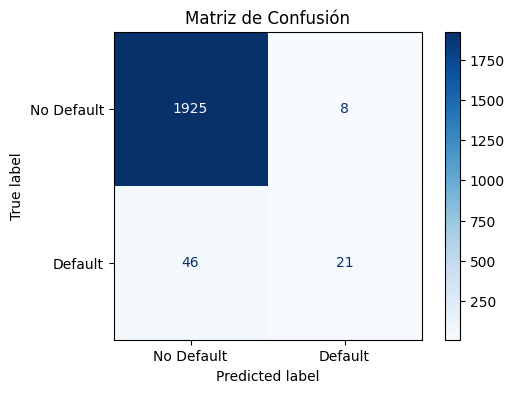


Reporte de Clasificación:
              precision    recall  f1-score   support

  No Default       0.98      1.00      0.99      1933
     Default       0.72      0.31      0.44        67

    accuracy                           0.97      2000
   macro avg       0.85      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



In [33]:
# Realizamos predicciones sobre el conjunto de prueba escalado
y_pred = log_reg.predict(X_test_scaled)

# Calculamos y visualizamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Matriz de Confusión')
plt.show()

# Imprimimos el reporte de clasificación completo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

### 4.2. El Impacto del Umbral de Decisión

Reporte de Clasificación con Umbral = 0.2:
              precision    recall  f1-score   support

  No Default       0.99      0.97      0.98      1933
     Default       0.39      0.63      0.48        67

    accuracy                           0.95      2000
   macro avg       0.69      0.80      0.73      2000
weighted avg       0.97      0.95      0.96      2000



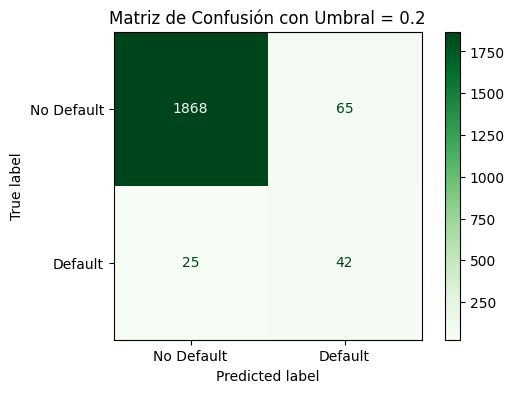

In [34]:
# Obtenemos las probabilidades de predicción para la clase positiva (Default)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Aplicamos un nuevo umbral de 0.2 para aumentar el Recall
umbral = 0.2
y_pred_nuevo_umbral = (y_pred_proba >= umbral).astype(int)

print(f"Reporte de Clasificación con Umbral = {umbral}:")
print(classification_report(y_test, y_pred_nuevo_umbral, target_names=['No Default', 'Default']))

# Visualizamos la nueva matriz de confusión
cm_nuevo = confusion_matrix(y_test, y_pred_nuevo_umbral)
disp_nuevo = ConfusionMatrixDisplay(confusion_matrix=cm_nuevo, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp_nuevo.plot(cmap='Greens', ax=ax)
ax.set_title(f'Matriz de Confusión con Umbral = {umbral}')
plt.show()

### 4.3. Curva ROC y AUC

In [35]:
# Calculamos la tasa de verdaderos positivos (tpr) y la tasa de falsos positivos (fpr)
fpr, tpr, umbrales = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Creamos el gráfico con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'Curva ROC (AUC = {auc:.4f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Clasificador Aleatorio', line=dict(dash='dash')))
fig.update_layout(
    title='Curva ROC para el Modelo de Regresión Logística',
    xaxis_title='Tasa de Falsos Positivos (FPR)',
    yaxis_title='Tasa de Verdaderos Positivos (TPR)',
    template='plotly_white'
)
fig.show()

In [36]:
pd.DataFrame({
    'Umbral': umbrales,
    'FPR': fpr,
    'TPR': tpr
})  # Mostramos las primeras filas de los umbrales y sus correspondientes FPR y TPR

,Umbral,FPR,TPR
0,inf,0.000000,0.000000
1,0.904982,0.000000,0.014925
2,0.876104,0.000000,0.029851
3,0.861995,0.000517,0.029851
4,0.723316,0.000517,0.179104
...,...,...,...
87,0.007660,0.320228,0.970149
88,0.007620,0.320228,0.985075
89,0.007012,0.332644,0.985075
90,0.007008,0.332644,1.000000


## 5. Regularización

El hiperparámetro `C` en `scikit-learn` es el inverso de la fuerza de regularización $\lambda$. Un valor de `C` pequeño implica una regularización más fuerte. Ahora que los datos están escalados, la comparación de coeficientes es mucho más justa.

In [37]:
# Modelo con regularización L2 (Ridge) - C=1.0 (default)
log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Modelo con regularización L1 (Lasso) - C=1.0 (default)
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Ahora con regularización más fuerte (C=0.1)
log_reg_l2_strong = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)
log_reg_l1_strong = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Creamos un DataFrame para comparar los coeficientes
coef_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coef_L2 (C=1.0)': log_reg_l2.coef_[0],
    'Coef_L1 (C=1.0)': log_reg_l1.coef_[0],
    'Coef_L2_fuerte (C=0.1)': log_reg_l2_strong.coef_[0],
    'Coef_L1_fuerte (C=0.1)': log_reg_l1_strong.coef_[0]
})

print("Comparación de Coeficientes con Regularización (Datos Escalados):")
display(coef_df)

Comparación de Coeficientes con Regularización (Datos Escalados):


,Predictor,Coef_L2 (C=1.0),Coef_L1 (C=1.0),Coef_L2_fuerte (C=0.1),Coef_L1_fuerte (C=0.1)
0,balance,2.594626,2.709366,1.921343,2.389894
1,income,-0.054058,-0.004069,-0.106268,0.002709
2,student_Yes,-0.658059,-0.561404,-0.670900,-0.323989


**Análisis:**
- Ahora los coeficientes son directamente comparables en magnitud.
- Se puede observar claramente cómo al aumentar la fuerza de la regularización (disminuir `C`), los coeficientes se "encogen" hacia cero.
- La regularización L1 es más agresiva y puede llevar coeficientes a cero, realizando una selección de variables.

## 6. Preguntas y Desafíos para Experimentar

Ahora te toca a ti. Intenta responder a las siguientes preguntas modificando el código anterior para solidificar tu aprendizaje:

1.  **Fuerza de Regularización vs. Rendimiento:** Crea un gráfico que muestre cómo cambia el AUC del modelo a medida que varías el hiperparámetro `C` (p. ej. `[0.001, 0.01, 0.1, 1, 10, 100]`). ¿Encuentras un valor óptimo para `C`?
2.  **Otros Escaladores:** En lugar de `StandardScaler`, prueba con `MinMaxScaler` de `sklearn.preprocessing`. ¿Cambian los resultados de rendimiento? ¿Y los coeficientes del modelo?
3.  **Selección de Predictores:** Entrena el modelo usando solo `balance` y `student_Yes` (ambos escalados). ¿Cuánto cae el rendimiento (AUC) al quitar la variable `income`? ¿Confirma esto que `income` es el predictor menos importante?

## 7. Ejercicios Propuestos

1.  Explica con tus propias palabras por qué el accuracy no es una buena métrica para evaluar un modelo en un dataset desbalanceado como `Default`.
2.  Si un banco te pide un modelo que minimice la cantidad de clientes en default que no son detectados, ¿en qué métrica te enfocarías (Precisión o Recall)? ¿Y cómo ajustarías el umbral de decisión?
3.  Carga un nuevo dataset de clasificación de `scikit-learn` (por ejemplo, `load_breast_cancer`) y realiza un análisis completo: estandarización, entrenamiento, evaluación con matriz de confusión y reporte de clasificación.
4.  ¿Qué representa un punto en la esquina superior izquierda de la curva ROC? ¿Y un punto en la línea diagonal?
5.  ¿Por qué es fundamental ajustar (`fit`) el `StandardScaler` únicamente con los datos de entrenamiento y no con todo el dataset?
6.  Crea un bucle `for` que itere sobre una lista de umbrales (ej. `[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`). Para cada umbral, calcula y guarda la Precisión y el Recall para la clase 'Default'. Luego, grafica cómo cambian estas dos métricas a medida que varía el umbral (Precision-Recall Curve).
7.  Usando los coeficientes del modelo `log_reg` (entrenado con datos escalados), interpreta el coeficiente de la variable `balance`. ¿Qué significa un aumento de una desviación estándar en el `balance` en términos del odds ratio de default?
8.  Explica la diferencia fundamental entre la regularización L1 y L2 en términos de su efecto sobre los coeficientes del modelo.
9.  Si tuvieras dos modelos, uno con AUC de 0.85 y otro con AUC de 0.75, ¿cuál elegirías y por qué? ¿Bajo qué circunstancias podrías preferir el de 0.75?
10. Investiga el parámetro `class_weight` de `LogisticRegression` en `scikit-learn`. ¿Cómo podrías usarlo para manejar el desbalanceo de clases en el dataset `Default`? Pruébalo (con los datos escalados) y compara los resultados (recall, precisión) con la técnica de ajustar el umbral.

## 1. 
En un modelo desbalanceado como el de Default existen muchoas observciones de NoDefault y pocas de default, por lo tanto en el accuracy (TP+TN)/TOTAL queda muy sesgado hacia los NoDefault (TN) , mientras se predigan  bien los NoDefault la métrica va a dar alta porque pesa mucho ese valor pero para los casos de Default el peso relativo en el total es bajo entonces no tiene inferencia en la métrica incluso cuando los FN sean muchos, esto es, dado que predigo mal los default el numerador es mas chico que el denomiador (pero poquito por el sesgo)

## 2. 
Los clientes en default son los TP, entonces los no detectados son los TP/(TP+FN), por lo tanto la métrica que se ajust es la recall que es del total de lo que habia cuando predije bien. 
Precisión mide la calidad de lo predicho esto es TP/(TP+FP) esto es, los que realmente eran positivos sobre los que predije como positivos, (incluyo los que predije como positovo y no eran "FP")

Minimizar la cantidad de clientes en default no detectados es minimizar los FN (Predije NoDefault y era default) para eso la mejor métrica es el recall (de hecho entre las dos es la única que tiene FN) y bajar el umbral de 0.5 a 02 o mas inclusive. 
Por qué bajar el umbral y no subirlo?. Porque se predice default si  $$P(y=1|default)>0.5$$

Ahora si bajo el umbral a 0.2 $$P(y=1|default)>0.2$$

cuando la probabilidad de que sea default sea mas baja lo va a predecir como 1 (default) esto hace que sea mas sensible.



### 3. 
Carga un nuevo dataset de clasificación de `scikit-learn` (por ejemplo, `load_breast_cancer`) y realiza un análisis completo: estandarización, entrenamiento, evaluación con matriz de confusión y reporte de clasificación.

### 3.1 Visualizamos los datos primero
- a vemos si hay variables categoricas

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


hay categorizados como No cancer: 212 casos
hay categorizados como Cancer: 357 casos


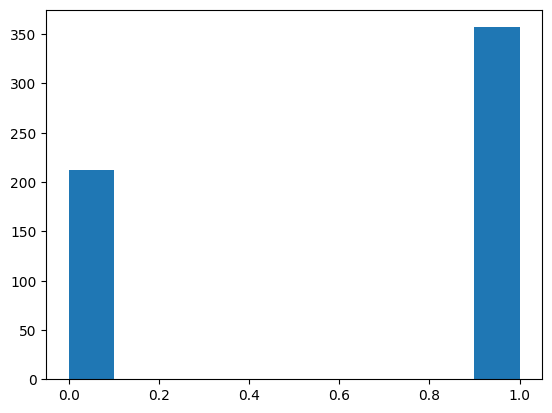

In [38]:
from sklearn.datasets import load_breast_cancer

breast_cancer_df,target=load_breast_cancer(return_X_y=True,as_frame=True)

columns_names=breast_cancer_df.columns
print(columns_names)

pd.set_option('display.max_columns', None)

display(breast_cancer_df)
print(f'hay categorizados como No cancer: {(target == 0).sum()} casos')
print(f'hay categorizados como Cancer: {(target == 1).sum()} casos')

plt.figure()
plt.hist(target,)
plt.show()

#### No hay variables categoricas. Dividimos en test y train

In [39]:
X_cancer=breast_cancer_df.copy()
y_cancer=target.copy()
X_train_cancer,X_test_cancer,y_train_cancer,y_test_cancer=train_test_split(X_cancer,
                                                                           y_cancer,
                                                                           test_size=0.2,
                                                                           random_state=42,
                                                                           stratify=y_cancer)

print(X_train_cancer.shape)
print(X_test_cancer.shape)

(455, 30)
(114, 30)


### Estandarizamos los features 

In [40]:
scaler_cancer= StandardScaler()

cols_to_scale_cancer=columns_names

X_train_cancer_scaled=X_train_cancer.copy()
X_test_cancer_scaled=X_test_cancer.copy()

X_train_cancer_scaled[cols_to_scale_cancer]=scaler_cancer.fit_transform(X_train_cancer[cols_to_scale_cancer])
X_test_cancer_scaled[cols_to_scale_cancer]=scaler_cancer.transform(X_test_cancer[cols_to_scale_cancer])

print("datos escalados")

display(X_train_cancer_scaled)
display(X_test_cancer_scaled)


datos escalados


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
546,-1.072001,-0.658425,-1.088080,-0.939274,-0.135940,-1.008718,-0.968359,-1.102032,0.281062,-0.113231,-0.704861,-0.440938,-0.743949,-0.629805,0.000748,-0.991573,-0.693760,-0.983284,-0.591579,-0.428972,-1.034094,-0.623497,-1.070773,-0.876534,-0.169982,-1.038836,-1.078995,-1.350527,-0.352658,-0.541380
432,1.748743,0.066502,1.751157,1.745559,1.274468,0.842288,1.519852,1.994664,-0.293045,-0.320180,0.127567,-0.381383,0.094075,0.317524,0.639656,0.087389,0.708451,1.182150,0.426212,0.074797,1.228342,-0.092833,1.187467,1.104386,1.517001,0.249655,1.178594,1.549916,0.191078,-0.173739
174,-0.974734,-0.931124,-0.997709,-0.867589,-0.613515,-1.138154,-1.092292,-1.243358,0.434395,-0.429247,-0.254445,1.237130,-0.338634,-0.413827,0.520240,-0.833114,-1.006736,-1.857894,1.356046,-1.006560,-0.973231,-1.036772,-1.008044,-0.834168,-1.097823,-1.167260,-1.282241,-1.707442,-0.307734,-1.213033
221,-0.145103,-1.215186,-0.123013,-0.253192,0.664482,0.286762,-0.129729,-0.098605,0.555635,0.029395,-0.531049,-1.262281,-0.411682,-0.436600,-0.393580,-0.129997,-0.219965,-0.527278,-0.269450,-0.316623,-0.251266,-1.369643,-0.166633,-0.330292,0.234006,0.096874,-0.087521,-0.344838,0.242198,-0.118266
289,-0.771617,-0.081211,-0.803700,-0.732927,-0.672282,-1.006099,-0.798502,-0.684484,0.737495,-0.457213,-0.498529,1.322961,-0.440597,-0.521457,-0.174225,-0.628196,-0.581187,-0.278344,1.528534,-0.313022,-0.801135,0.079230,-0.824381,-0.741830,-0.911367,-0.984612,-0.933190,-0.777604,0.555118,-0.761639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,0.346953,0.718708,0.305215,0.180108,-0.416385,0.024898,-0.434051,-0.404147,-0.282347,0.048971,-0.723550,-1.266660,-0.750036,-0.472556,-1.211293,-0.628196,-0.458099,-0.901474,-1.034792,-0.440135,0.340577,0.383156,0.216376,0.188430,-0.098951,0.473190,0.400659,0.130349,0.412600,0.749172
300,1.562791,-0.078938,1.572901,1.649786,1.400929,1.128468,1.598229,1.488000,-0.050565,0.377571,2.661483,-0.101121,2.239354,2.247420,-0.328125,0.351939,0.736903,0.900429,-0.221473,0.356389,2.046849,0.095311,1.944436,2.143641,0.762298,0.984755,1.555508,1.260606,0.091935,0.834556
509,0.398448,1.068673,0.507514,0.240184,1.646411,1.554933,1.393715,0.947901,0.002923,1.120068,-0.246222,1.300189,0.058058,-0.161174,0.783658,1.293585,0.854733,1.390656,0.030976,0.793181,0.195764,1.717856,0.333992,0.073098,1.814443,1.517608,1.458150,1.534925,0.161645,1.237548
230,0.853314,-0.038033,0.905480,0.715275,1.333979,0.997536,1.246759,1.560013,1.158269,0.060158,-0.385271,-0.945410,-0.339648,-0.174118,-0.495435,-0.295883,-0.061930,0.344944,-1.029081,-0.526197,0.716251,-0.121779,0.810491,0.579327,1.685699,0.870796,1.044148,2.104551,0.310359,0.362496


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
256,1.568513,2.164016,1.742866,1.620764,-0.265376,1.915932,1.092455,1.698896,0.309589,-0.069884,1.658233,-0.034558,2.199279,1.609795,-0.232337,1.198715,0.187957,0.559817,-0.162073,0.523832,1.862160,1.708208,2.170622,1.913701,-0.187740,1.744275,0.688560,1.202144,-0.140431,0.900362
428,-0.840276,-0.597067,-0.874174,-0.776170,-1.090346,-1.225691,-0.924639,-0.891008,-1.052578,-0.187341,-0.962401,-0.440763,-0.940773,-0.708094,-0.383363,-1.044917,-0.716089,-0.872824,-0.078685,-0.511433,-0.943849,-0.861492,-0.973363,-0.810993,-1.302037,-1.203075,-1.069908,-1.101241,-0.814291,-0.713236
501,-0.070723,1.191387,0.032028,-0.152775,1.490195,1.201416,0.569536,0.494989,1.671757,1.335406,0.284559,0.541730,0.076827,-0.004644,0.828998,0.705937,0.068271,0.714206,0.406793,1.151473,-0.035096,1.172720,-0.018858,-0.146703,2.089687,0.890832,0.285220,0.572558,1.149974,1.868412
363,0.695970,-0.217560,0.623587,0.550139,0.051519,-0.358921,-0.374411,0.000156,-1.109632,-0.963397,-0.224542,0.385835,-0.242758,-0.135765,0.055347,-0.405931,-0.440162,-0.213723,-0.438511,-0.646828,0.409835,-0.031727,0.318913,0.253429,0.065307,-0.541172,-0.511259,-0.339891,-0.797251,-1.047159
564,2.143533,0.714163,2.091086,2.410164,1.103374,0.225037,1.894590,2.329011,-0.285913,-0.921448,2.904446,0.065285,2.460528,2.863472,1.026960,0.182801,0.600826,2.048006,-1.101046,0.159059,1.946110,0.121040,1.793646,2.096566,0.384946,-0.269423,0.621800,1.614373,-1.314652,-0.695833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.771629,0.859603,1.693120,1.786189,-0.400763,0.513087,0.701797,0.989823,1.029898,-0.885092,1.340512,0.508449,0.878327,1.165614,-0.340897,0.503188,0.302076,0.161905,0.661527,0.220994,1.687965,0.955630,1.492065,1.595045,-0.591728,0.623466,0.617628,0.650507,1.208840,-0.014391
128,0.295459,-0.649335,0.332575,0.075338,1.400929,1.437094,0.301342,0.951502,0.694705,0.258716,0.119344,-0.264023,-0.013468,0.014293,0.613793,0.884291,-0.015849,1.736043,0.314267,0.427327,-0.014109,-1.176674,-0.021874,-0.192690,0.278400,0.212712,-0.373568,0.425655,-0.493627,-0.334718
257,0.358397,-0.449355,0.482641,0.187944,2.777118,2.329303,1.905612,1.950942,2.110360,1.837395,0.972704,-0.279788,0.628239,0.484601,0.979066,1.102762,0.534334,1.527538,-0.221473,1.751026,0.325886,-0.480379,0.397324,0.108223,1.960944,1.227075,0.771082,1.633860,0.541176,1.911919
228,-0.414018,1.073218,-0.423146,-0.441545,-1.274830,-0.534557,-0.426336,-0.719719,-1.041880,-0.367722,-0.575904,-0.267526,-0.698801,-0.497006,-0.611339,-0.140839,-0.073991,-0.474594,-0.814328,-0.140538,-0.414967,0.910604,-0.481182,-0.443632,-0.427469,0.570244,0.530933,0.061395,-0.128038,0.647472


#### Entrenamiento

In [41]:
log_reg_cancer=LogisticRegression(random_state=42)
log_reg_cancer.fit(X_train_cancer_scaled,y_train_cancer)


log_reg_cancer


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


#### Evaluación del modelo

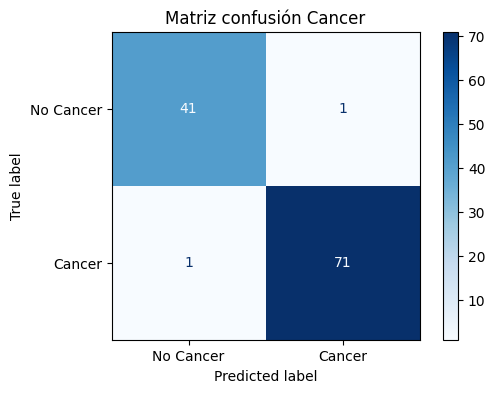


Reporte de Clasicación para Cancer
              precision    recall  f1-score   support

   No Cancer       0.98      0.98      0.98        42
      Cancer       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [42]:
y_cancer_pred=log_reg_cancer.predict(X_test_cancer_scaled)

cm_cancer=confusion_matrix(y_test_cancer,y_cancer_pred)

disp_cm_cancer=ConfusionMatrixDisplay(confusion_matrix=cm_cancer,display_labels=['No Cancer', 'Cancer'])
fig_cancer, ax_cancer=plt.subplots(figsize=(6,4))
disp_cm_cancer.plot(cmap="Blues",ax=ax_cancer)

ax_cancer.set_title("Matriz confusión Cancer")
plt.show()

print('\nReporte de Clasicación para Cancer')
print(classification_report(y_test_cancer,y_cancer_pred,target_names=['No Cancer','Cancer']))

### 4.  ¿Qué representa un punto en la esquina superior izquierda de la curva ROC? ¿Y un punto en la línea diagonal?

La curva ROC dibuja el impacto de todos los umbrales posibles entre TPR (eje y) y FPR (eje x) por lo tanto un punto en la esquina superir izq implica el maximo TPR y el mínimo FPR, o sea, que predijo los positivos en un 100% para ESE Uumbral, es decir es el umbral óptimo.
Los puntos de la linea diagonal son un 50%. 50% es un comportamiento aleatorio


### 5.  ¿Por qué es fundamental ajustar (`fit`) el `StandardScaler` únicamente con los datos de entrenamiento y no con todo el dataset?

Esto es para evitar filtado de datos. El escalamiento se hace estandarizando. Para estandarizar se usa la media y el desvio, si se entrena todo los datos juntos los datos de test influyen en la estandarización de los datos de entrenamiento y se esta filtrando información.


### 6.  Crea un bucle `for` que itere sobre una lista de umbrales (ej. `[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`). Para cada umbral, calcula y guarda la Precisión y el Recall para la clase 'Default'. Luego, grafica cómo cambian estas dos métricas a medida que varía el umbral (Precision-Recall Curve).


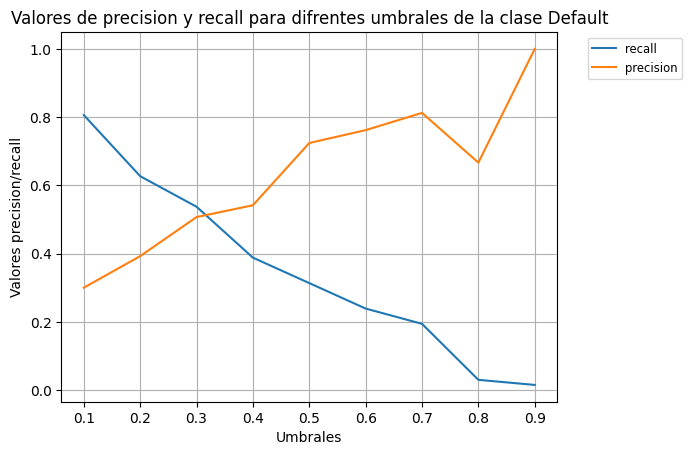

In [43]:
umbrales_default=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#Precision: TP/(TP+FP)
#Recall: TP/(TP+FN)

y_pred_proba=log_reg.predict_proba(X_test_scaled)[:,1]
precision=[]
recall=[]
for i,umbral in enumerate(umbrales_default):
    y_pred_nuevo_umbral=(y_pred_proba>=umbral).astype(int)
    cr=classification_report(y_test,y_pred_nuevo_umbral,target_names=['No default','Default'],output_dict=True)
    precision.append(cr['Default'].get('precision'))
    recall.append(cr['Default'].get('recall'))

plt.figure()
plt.plot(umbrales_default,recall,label='recall')
plt.plot(umbrales_default,precision,label='precision')
plt.xlabel('Umbrales')
plt.ylabel('Valores precision/recall')
plt.legend(loc='best', fontsize='small', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.title("Valores de precision y recall para difrentes umbrales de la clase Default")
plt.show()




### 7.  Usando los coeficientes del modelo `log_reg` (entrenado con datos escalados), interpreta el coeficiente de la variable `balance`. ¿Qué significa un aumento de una desviación estándar en el `balance` en términos del odds ratio de default?


In [44]:
log_reg.coef_

array([[ 2.7084448 , -0.02143334, -0.58993015]])

El Coeficiente de la variable balance es de 2.71 y significa que un incremento de una unidad en el balance hace que esas cuentas sean 15 veces mas propensas a entrar en default en comparación a aquellas cuyo balnce no aumenta, manteniendo todo lo demas constante.

Esto significa por ejemplo que si las probabilidades eran de 0.8 lo que es una proporción de $4/1$ lo que es $(0.8/1-0.8)$ ahora si hay 15 veces mas, entonces se multiplica por 15 el numerador: 


Ahora 4*15=60, por lo tanto odds=60=$\frac{p}{1-p}$ despejando:
$$
    60*(1-p)=p \Longrightarrow  60-60p=p \Longrightarrow 60=61p \Longrightarrow p=\frac{60}{61} =0.9836
$$


Las variables ya estan estandarizadas, con lo cual todo se mide en desvios estándar, asi que un incremento en una unidad del desvio estandar del balance no cambia la interpretación primera. 
Si no hubiera estado estandarizado debería multiplicar el coeficiente (regresor) de balance por el incremento de la desviación estandar (que lo deja igual de todmos modos).
Dado que el desvío es de 438 podemos decir que: 

Un incremento de 438 pesos en balance implica que esas cuentas son 15 veces mas propensas a entrar en default en comparación a quellas cuyo balance no aumentó. Esto es un incremento de 438 pesos en el balance incremnta 15 veces odds (p/1-p)

### 8.  Explica la diferencia fundamental entre la regularización L1 y L2 en términos de su efecto sobre los coeficientes del modelo.


L2 (Ridge) lo que hace es penalizar el cuadrado los coeficiente en lugar del módulo como lo hace L1 (Lasso) esto hace que L1 pueda llevar los coeficientes a 0 y descartarlos del modelo.

### 9.  Si tuvieras dos modelos, uno con AUC de 0.85 y otro con AUC de 0.75, ¿cuál elegirías y por qué? ¿Bajo qué circunstancias podrías preferir el de 0.75?


Si AUC es el área bajo la curva del ROC es mejor el de 0.85 porque maximiza la tasa de TP. 
Podría llegar a elegir 0.75 en el caso donde se diera para un umbral particular una tasa de TP que sea mas grande que culaquier otra de la ROC para el 0.85 y solo se quiera usar ese umbral.
También se puede dar que el modelo de 0.75 ofrezca mayor simplicidad para explicar y por lo tanto convenga usarlo sin embargo no soy fan de perder performance en base a tener capacidad explicativa.

### 10. Investiga el parámetro `class_weight` de `LogisticRegression` en `scikit-learn`. ¿Cómo podrías usarlo para manejar el desbalanceo de clases en el dataset `Default`? Pruébalo (con los datos escalados) y compara los resultados (recall, precisión) con la técnica de ajustar el umbral.

El parámetro class_weight asocia un peso a cada clase, si no lo tiene asume. Dado que mi dataset es desbalanceado puedo usarlo para modificar el peso que tiene según la cantidad de ejemplos que tengo.

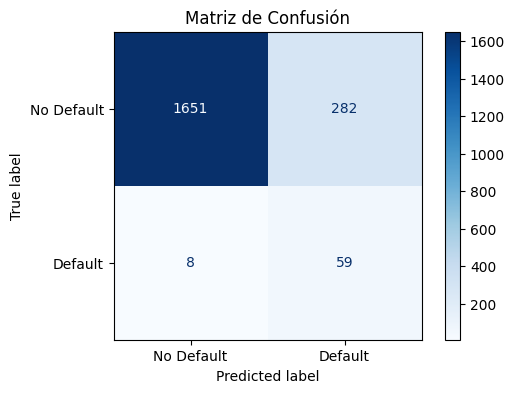


Reporte de Clasificación balanced:
              precision    recall  f1-score   support

  No Default       1.00      0.85      0.92      1933
     Default       0.17      0.88      0.29        67

    accuracy                           0.85      2000
   macro avg       0.58      0.87      0.60      2000
weighted avg       0.97      0.85      0.90      2000

Reporte de Clasificación con Umbral = 0.9:
              precision    recall  f1-score   support

  No Default       0.97      1.00      0.98      1933
     Default       1.00      0.01      0.03        67

    accuracy                           0.97      2000
   macro avg       0.98      0.51      0.51      2000
weighted avg       0.97      0.97      0.95      2000



In [45]:
# Instanciamos y entrenamos el modelo con los datos escalados
log_reg_balanced = LogisticRegression(random_state=42,class_weight='balanced')
log_reg_balanced.fit(X_train_scaled, y_train)

# Realizamos predicciones sobre el conjunto de prueba escalado
y_pred_balanced = log_reg_balanced.predict(X_test_scaled)

# Calculamos y visualizamos la matriz de confusión
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp_balanced.plot(cmap='Blues', ax=ax)
ax.set_title('Matriz de Confusión')
plt.show()

# Imprimimos el reporte de clasificación completo
print("\nReporte de Clasificación balanced:")
print(classification_report(y_test, y_pred_balanced, target_names=['No Default', 'Default']))

print(f"Reporte de Clasificación con Umbral = {umbral}:")
print(classification_report(y_test, y_pred_nuevo_umbral, target_names=['No Default', 'Default']))


Aca se puede ver que para default obtuve un mejor recall que bajando el umbral a 0.2. Esto nos dice que se le "escapan" menos casos de default. Sin embargo para No default bajo bastante lo que implica que peca de conservadora. 

Para la precision, o sea que tan bien bien predice cuando acierta, y se ve que bajo a casi la mitad, eso es, nuevamente, que vuelvo a ser conservador, marco como Default casos que no lo son.